In [155]:
import cv2
import copy
import matplotlib.pyplot as plt
import os

from PIL import Image

%matplotlib inline

%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from modules.pascal_voc_dataset import Dataset
from modules.utils import DrawBBoxes

In [203]:
ROOT_DIR = os.path.abspath('../../')
dataset = Dataset(ROOT_DIR)
dataset.AddImage(2012, imageset='trainval')
dataset.Prepare()
dataset.SaveAnnotation()

Processing :: 2008_000060.jpg: 100%|██████████| 30/30 [00:00<00:00, 679.91it/s]


In [212]:
idx = np.random.randint(0, len(dataset.ann_datas))
ann = dataset.ann_datas[idx]

width = int(ann['width'])
height = int(ann['height'])
img = np.array(Image.open(ann['filepath']))


In [290]:
def get_new_img_size(w, h, img_min=600):
    print('w : {}, h : {}'.format(w, h))
    if w <= h:
        factor = float(img_min) / w
        resize_h = int(factor * h)
        resize_w = int(img_min)
    else:
        factor = float(img_min) / h
        resize_h = int(img_min)
        resize_w = int(factor * w)
    
    return {'w': resize_w, 'h':resize_h}
    
resized = get_new_img_size(width, height, img_min=600)
print("Resized :: ", resized)

resize_img = cv2.resize(img, (resized['w'], resized['h']), interpolation=cv2.INTER_CUBIC)


w : 500, h : 375
Resized ::  {'w': 800, 'h': 600}


In [291]:
downscale = float(16)
anchor_sizes = [128, 256, 512]
anchor_ratios = [[1, 1], [1, 2], [2, 1]]
num_anchors = len(anchor_sizes) * len(anchor_ratios)

# if backbone network is VGG16, feature map size 16x16
output_size = {'w':resized['w']/16, 'h':resized['h']/16}
print('Output Size::', output_size)

num_bboxes = len(ann['bboxes'])
print('Num of BBoxes ::', num_bboxes)

Output Size:: {'w': 50.0, 'h': 37.5}
Num of BBoxes :: 5


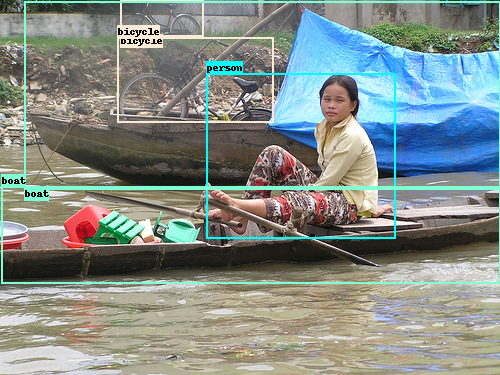

In [292]:
result_img = DrawBBoxes(Image.fromarray(img), ann['bboxes'], dataset.class_mapping, method='pil')
result_img

In [293]:
def ComputeIOU(gt, p):
    if gt[0] >= gt[2] or gt[1] >= gt[3] or p[0] >= p[2] or p[1] >= p[3]:
        return 0.0
    
    x1 = np.maximum(gt[0], p[0])
    y1 = np.maximum(gt[1], p[1])
    x2 = np.minimum(gt[2], p[2])
    y2 = np.minimum(gt[3], p[3])

    # Intersection
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    
    # Union
    gt_area = (gt[2] - gt[0]) * (gt[3] - gt[1])
    propoesed_area = (p[2] - p[0]) * (p[3] - p[1])
    union = gt_area + propoesed_area - intersection

    iou = float(intersection) / float(union + 1e-7)
    
    return iou    

In [294]:
gt_bbox = np.zeros((num_bboxes, 4))
for idx, bbox in enumerate(ann['bboxes']):
    gt_bbox[idx, 0] = bbox['x1'] * (resized['w'] / float(width))
    gt_bbox[idx, 1] = bbox['y1'] * (resized['h'] / float(height))
    gt_bbox[idx, 2] = bbox['x2'] * (resized['w'] / float(width))
    gt_bbox[idx, 3] = bbox['y2'] * (resized['h'] / float(height))

In [325]:
y_rpn_overlap = np.zeros((int(output_size['h']), int(output_size['w']), num_anchors))
y_is_box_valid = np.zeros((int(output_size['h']), int(output_size['w']), num_anchors))
y_rpn_regr = np.zeros((int(output_size['h']), int(output_size['w']), num_anchors * 4))

num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
best_anchor_for_bbox = -1 * np.ones((num_bboxes, 4)).astype(int)
best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

for anchor_size_idx in range(len(anchor_sizes)):
    for anchor_ratio_idx in range(len(anchor_ratios)):
        anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
        anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]
        print('Anchor Size ::', anchor_x, anchor_y)
        
        for ix in range(int(output_size['w'])):
            # x-coordinates of the current anchor box
            x1_anc = downscale * (ix + 0.5) - anchor_x / 2
            x2_anc = downscale * (ix + 0.5) + anchor_x / 2
            
            if anchor_size_idx == 0 and anchor_ratio_idx == 2 and ix == 7:
                print("!!!!!!!!!!!!!!!!!!!!!!!", x1_anc, x2_anc)
            
            if x1_anc < 0 or x2_anc > resized['w']:
                continue
            
            for jy in range(int(output_size['h'])):
                y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                y2_anc = downscale * (jy + 0.5) + anchor_y / 2
                

                
                if y1_anc < 0 or y2_anc > resized['h']:
                    continue
                
                bbox_type = 'neg'
                best_iou_for_loc = 0.0
            
                for idx, gt in enumerate(gt_bbox):
                    curr_iou = ComputeIOU(gt, np.array([x1_anc, y1_anc, x2_anc, y2_anc]))

                    if curr_iou > best_iou_for_bbox[idx] or curr_iou > 0.7:
                        cx = (gt[0] + gt[2]) / 2.0
                        cy = (gt[1] + gt[3]) / 2.0
                        cxa = (x1_anc + x2_anc) / 2.0
                        cya = (y1_anc + y2_anc) / 2.0
                        
                        tx = (cx - cxa) / (x2_anc - x1_anc)
                        ty = (cy - cya) / (y2_anc - y1_anc)
                        tw = np.log((gt[2] - gt[0]) / (x2_anc - x1_anc))
                        th = np.log((gt[3] - gt[1]) / (y2_anc - y1_anc))
                    
                    if ann['bboxes'][idx]['class'] != 'bg':
                        if curr_iou > best_iou_for_bbox[idx]:
                            best_anchor_for_bbox[idx] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
                            best_iou_for_bbox[idx] = curr_iou
                            best_x_for_bbox[idx, :] = [x1_anc, x2_anc, y1_anc, y2_anc]
                            best_dx_for_bbox[idx, :] = [tx, ty, tw, th]
                        
                        if curr_iou > 0.7:
                            bbox_type = 'pos'
                            num_anchors_for_bbox[idx] += 1
                            
                            if curr_iou > best_iou_for_loc:
                                best_iou_for_loc = curr_iou
                                best_regr = (tx, ty, tw, th)
                        
                        if 0.3 < curr_iou < 0.7:
                            if bbox_type != 'pos':
                                bbox_type = 'neutral'
                
                if bbox_type == 'neg':
                    y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                    y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                elif bbox_type == 'neutral':
                    y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                    y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 0
                elif bbox_type == 'pos':
                    y_is_box_valid[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                    y_rpn_overlap[jy, ix, anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx] = 1
                    start = 4 * (anchor_ratio_idx + len(anchor_ratios) * anchor_size_idx)
                    y_rpn_regr[jy, ix, start:start+4] = best_regr

Anchor Size :: 128 128
Anchor Size :: 128 256
Anchor Size :: 256 128
!!!!!!!!!!!!!!!!!!!!!!! -8.0 248.0
Anchor Size :: 256 256
Anchor Size :: 256 512
Anchor Size :: 512 256
Anchor Size :: 512 512
Anchor Size :: 512 1024
Anchor Size :: 1024 512


In [326]:
num_anchors_for_bbox

array([ 0,  8, 14,  0,  0])

In [327]:
for idx in range(num_anchors_for_bbox.shape[0]):
    if num_anchors_for_bbox[idx] == 0:
        if best_anchor_for_bbox[idx, 0] == -1:
            continue
        y_is_box_valid[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1],
                      best_anchor_for_bbox[idx, 2] + len(anchor_ratios) * best_anchor_for_bbox[idx, 3]] = 1
        y_rpn_overlap[best_anchor_for_bbox[idx, 0], best_anchor_for_bbox[idx, 1],
                      best_anchor_for_bbox[idx, 2] + len(anchor_ratios) * best_anchor_for_bbox[idx, 3]] = 1
        start = 4 * (best_anchor_for_bbox[idx,2] + len(anchor_ratios) * best_anchor_for_bbox[idx,3])
        y_rpn_regr[best_anchor_for_bbox[idx,0], 
                   best_anchor_for_bbox[idx,1], 
                   start:start+4] = best_dx_for_bbox[idx, :]
        
        
y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

num_pos = len(pos_locs[0])

In [328]:
print(pos_locs)
print(len(neg_locs[0]))

(array([0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 5, 5]), array([ 4,  7,  7,  7,  7,  7,  8,  8,  8, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 10, 20]), array([16, 17, 18, 19, 20, 21, 18, 19, 20, 28, 29, 30, 31, 27, 28, 29, 30,
       31, 32, 28, 29, 30, 31, 33, 16]))
3464


In [329]:
import random
num_regions = 256

if len(pos_locs[0]) > num_regions/2:
    val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
    y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
    num_pos = num_regions/2

if len(neg_locs[0]) + num_pos > num_regions:
    val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
    y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)


In [349]:
valid = y_rpn_cls[:,:9,:,:]
overlap = y_rpn_cls[:,9:,:,:]

print(valid.shape)

a = np.where(np.logical_and(valid[0, :, :, :] == 1, overlap[0, :, :, :] == 1))
b = np.where(np.logical_and(valid[0, :, :, :] == 1, overlap[0, :, :, :] == 0))

print(a)
idx = a[0][20]
x = a[2][20]
y = a[1][20]

boxsize_w = anchor_sizes[idx//len(anchor_ratios)] * anchor_ratios[idx % len(anchor_ratios)][0]
boxsize_h = anchor_sizes[idx//len(anchor_ratios)] * anchor_ratios[idx % len(anchor_ratios)][1]
print(boxsize_w, boxsize_h)

print(idx, x, y)

x1 = downscale * (x + 0.5) - boxsize_w / 2
x2 = downscale * (x + 0.5) + boxsize_w / 2
y1 = downscale * (y + 0.5) - boxsize_h / 2
y2 = downscale * (y + 0.5) + boxsize_h / 2

print(x1, y1, x2, y2)

(1, 9, 37, 50)
(array([0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 5, 5]), array([ 4,  7,  7,  7,  7,  7,  8,  8,  8, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 15, 16, 16, 16, 16, 10, 20]), array([16, 17, 18, 19, 20, 21, 18, 19, 20, 28, 29, 30, 31, 27, 28, 29, 30,
       31, 32, 28, 29, 30, 31, 33, 16]))
256 256
3 29 16
344.0 136.0 600.0 392.0


(-0.5, 499.5, 374.5, -0.5)

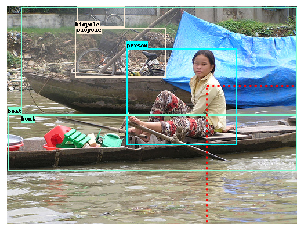

In [350]:
from matplotlib import patches

_, ax = plt.subplots(1)

p = patches.Rectangle((x1, y1), (x2 - x1), (y2 - y1), linewidth=2, alpha=1.0, linestyle=':', edgecolor='red', facecolor='none')
ax.add_patch(p)

plt.imshow(result_img)
plt.axis('off')
